In [1]:
import pandas as pd
import praw
from prawcore.exceptions import NotFound
from textblob import TextBlob
import networkx as nx
G = nx.Graph()
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')

reddit = praw.Reddit(client_id="UJB8dd4JEV3M405S2NTn1g",  # your client id
                     client_secret="Mc3huEYmHcU6c0HSTOZLefZqLZqHHw",  # your client secret
                     user_agent="EpicGames")  # your user agent

def get_posts(subred_name, n):
    try:
        subreddit = reddit.subreddit(subred_name)
        posts_info = []

        for subm in subreddit.top(limit=n):

            subred_info = []
            subred_info.append(subred_name)
            subred_info.append(str(subm.author))
            subred_info.append(subm.title)
            subred_info.append(subm.score)
            subred_info.append(subm.id)
            subred_info.append(subm.subreddit)
            subred_info.append(subm.url)
            subred_info.append(subm.num_comments)
            subred_info.append(subm.selftext)
            subred_info.append(subm.created_utc)
            
            posts_info.append(subred_info)

        posts_df = pd.DataFrame(posts_info, columns=['subreddit','author', 'title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created_utc'])

        return posts_df

    except praw.exceptions.Redirect:
        print(f"Redirect error: {subred_name}")
        return pd.DataFrame(columns=['subreddit','author', 'title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created_utc'])

In [6]:
prog_df = get_posts('Activision', 1500)
prog_df.to_csv('Influ_Acti.csv', index=False)

In [7]:
freqauthors = prog_df[prog_df.duplicated(['author'], keep = False)] #Authors who has posted more than once
freqauthors = freqauthors[freqauthors.author != 'None']
freqauthors = freqauthors[freqauthors.author != '[deleted]']
influential_ppl = list(freqauthors.author.unique())
pp  = len(influential_ppl)
print(pp)

71


In [8]:
# Create an empty DataFrame with desired column names
df_influ_users = pd.DataFrame(columns=['user', 'comment', 'subreddit'])

# Retrieve the 50 recent comments from each user and append to the DataFrame
for user in influential_ppl:
    redditor = reddit.redditor(user)
    try:
        comments = redditor.comments.new(limit=25)
        for comment in comments:
            df_influ_users = df_influ_users.append({
                'user': user,
                'comment': comment.body,
                'subreddit': comment.subreddit.display_name
            }, ignore_index=True)
        time.sleep(2) # rate limiting
    except Exception as e:
        print(f"Error processing user {user}: {e}")

df_influ_users.to_csv("influ_comments.csv", index=False)

Error processing user GhettoWario: received 403 HTTP response
Error processing user SmellyStinkyFarts: received 403 HTTP response
Error processing user EluneNoYume: received 403 HTTP response


In [9]:
df_influ_users

,user,comment,subreddit
0,VitaminWIZZ,"Even if you don't live in LA, I'm sure Activis...",activision
1,VitaminWIZZ,https://twitter.com/roundhill/status/118062710...,activision
2,VitaminWIZZ,Fuck you @ 13rock_SvK,hearthstone
3,VitaminWIZZ,If you live near LA you can enjoy the beaches ...,activision
4,VitaminWIZZ,Come to Los Angeles and take a good shit on th...,activision
...,...,...,...
1453,nucleotid3,"Sorry, but there is no setting that is going t...",activision
1454,nucleotid3,From what I've seen in previous comments and r...,activision
1455,nucleotid3,Everything about him just screams 'fraud' to m...,pics
1456,nucleotid3,Anyone know when the latest update is due out?...,Android


Text(0, 0.5, 'Number of posts')

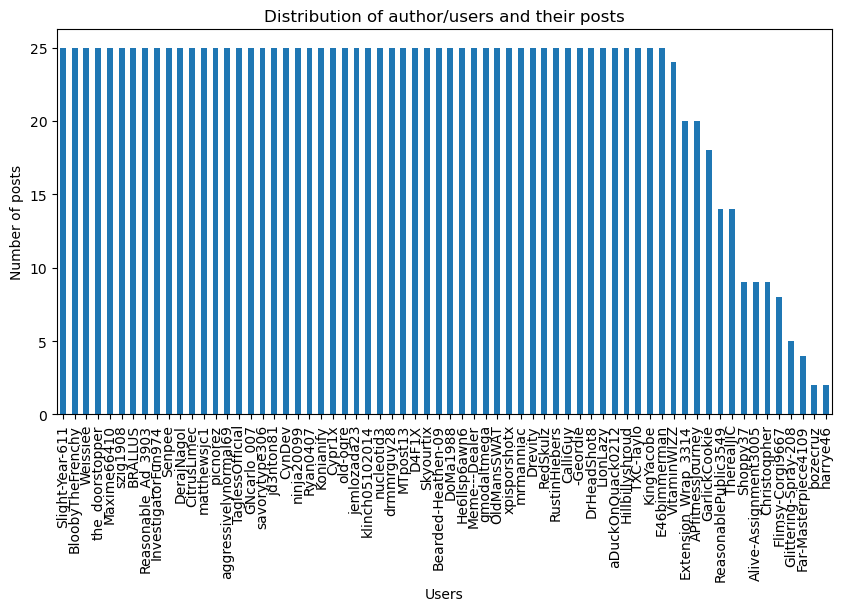

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
ax = df_influ_users['user'].value_counts().plot(kind='bar',title='Distribution of author/users and their posts')
ax.set_xlabel("Users")
ax.set_ylabel("Number of posts")

In [11]:
df_influ = df_influ_users[['user', 'subreddit']]

In [12]:
import networkx as nx
G = nx.Graph()
g = nx.from_pandas_edgelist(df_influ, source='user', target='subreddit')

In [13]:
leaderboard = {}
for x in g.nodes:
 leaderboard[x] = len(g[x])
s = pd.Series(leaderboard, name='connections')
df_conn = s.to_frame().sort_values('connections', ascending=False)

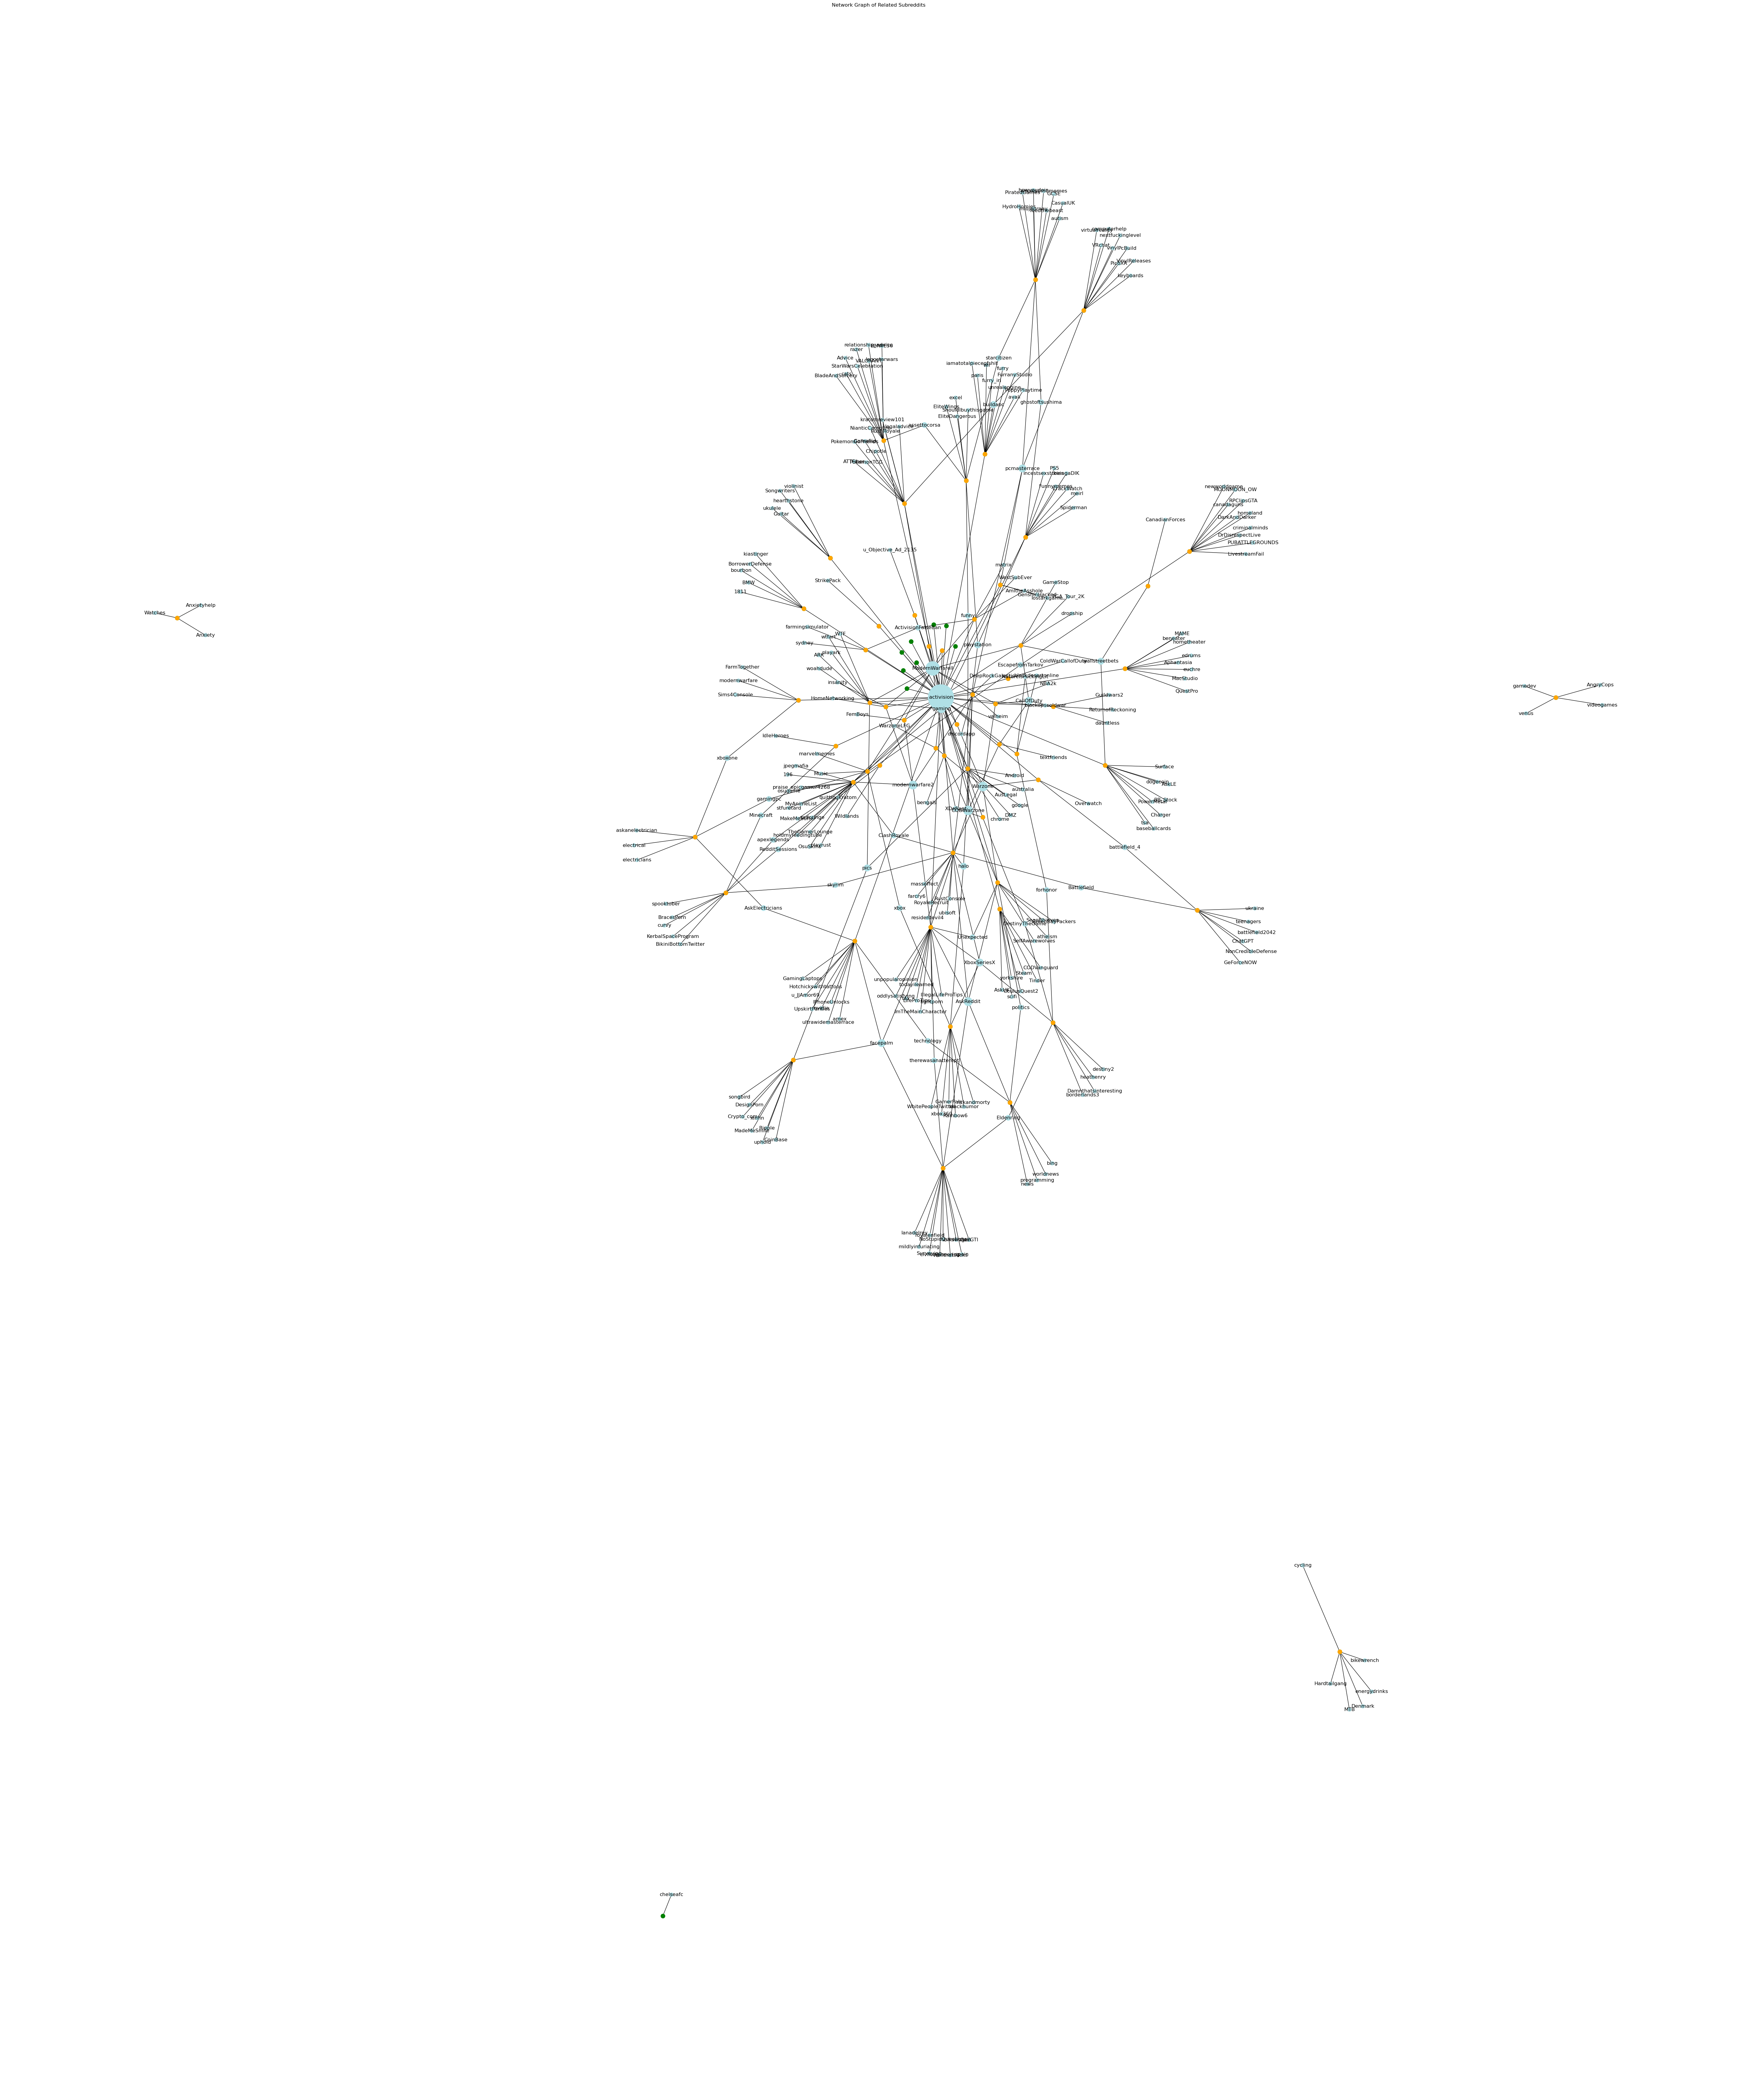

In [31]:
subs = list(df_influ['subreddit'].unique())
plt.figure(figsize=(75, 90))
# Create the graph from the dataframe [5]
g = nx.from_pandas_edgelist(df_influ, source='user', target='subreddit')
# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)
sub_size = [g.degree(sub) * 80 for sub in subs] #multiplying by 80 to get circular size

# Remove nodes that are not present in the layout
influential_ppl = [person for person in influential_ppl if person in layout.keys()]

nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, 
                       node_color='powderblue')
# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=influential_ppl, node_color='green', node_size=100)
# Draw highly connected influencers 
popular_people = [person for person in influential_ppl if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)
nx.draw_networkx_edges(g, layout, width=1, edge_color="black")
node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.show()